<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/InverseLinkPredcition/blob/main/InverseLinkPredcitionMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


216/216 [==============================] - 1s 2ms/step
Best combination coefficient (a): 0.7 with modularity: -1
Features of the remaining nodes saved to remaining_node_features.csv.


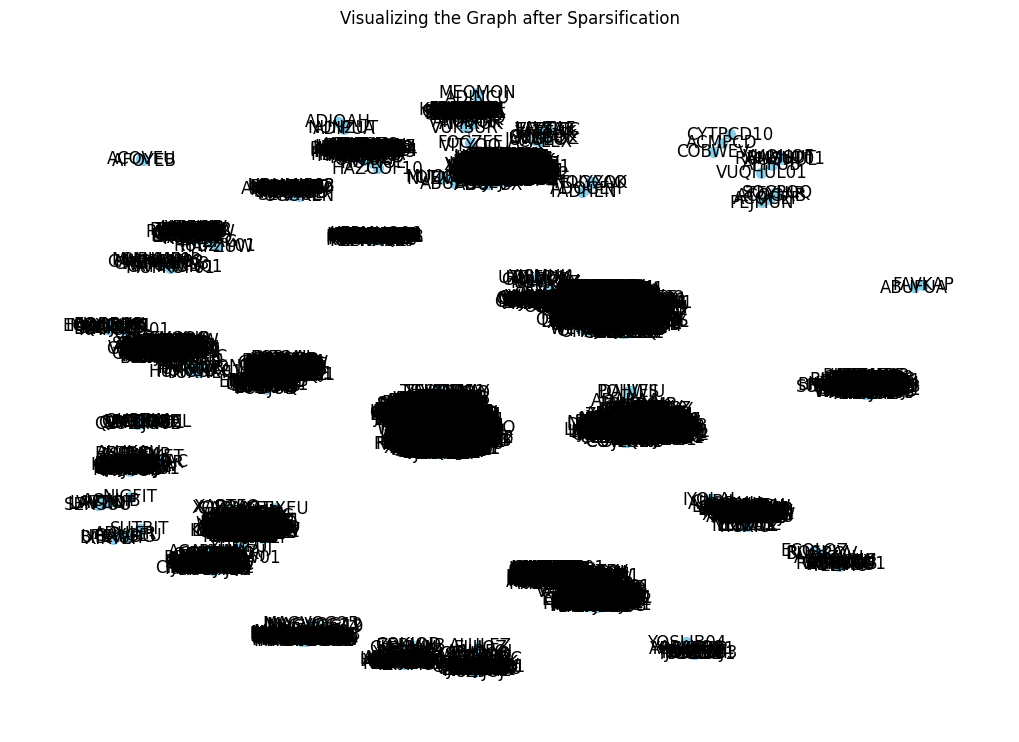

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from tensorflow.keras import layers, models
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt

def load_edges_list(filename):
    return pd.read_csv(filename)

def load_summary_data(filename, node_labels):
    summary_data = pd.read_csv(filename, index_col=0)  # Set the first column as index
    features = summary_data.iloc[:, -3:].astype('float32')  # Keep only the last three columns and convert to float32
    features = features.reindex(node_labels)  # Align the index with the node labels from the edge list
    return features  # Return only the selected features, properly indexed


def build_and_compile_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def predict_link_importance(model, node_features):
    node_features = node_features.astype(np.float32)
    return model.predict(node_features).flatten()

def optimize_combination_for_modularity(graph, features, importance_scores, initial_weights, threshold=0.2):
    best_modularity = -1
    best_a = 0.7
    a=best_a
    # for a in np.arange(0, 1.1, 0.1):
    #     combined_scores = a * importance_scores + (1 - a) * initial_weights
    #     edges_to_remove = [(list(graph.edges())[i][0], list(graph.edges())[i][1])
    #                        for i, score in enumerate(combined_scores) if score < threshold]

    #     graph_copy = graph.copy()
    #     graph_copy.remove_edges_from(edges_to_remove)
    #     communities = nx_comm.greedy_modularity_communities(graph_copy)

    #     modularity = nx_comm.modularity(graph_copy, communities)

    #     if modularity > best_modularity:
    #         best_modularity = modularity
    #         best_a = a

    combined_scores = a * importance_scores + (1 - a) * initial_weights
    edges_to_remove = [(list(graph.edges())[i][0], list(graph.edges())[i][1])
                        for i, score in enumerate(combined_scores) if score < threshold]

    graph_copy = graph.copy()
    graph_copy.remove_edges_from(edges_to_remove)
    communities = nx_comm.greedy_modularity_communities(graph_copy)

    modularity = nx_comm.modularity(graph_copy, communities)


    print(f"Best combination coefficient (a): {best_a} with modularity: {best_modularity}")
    return best_a

def remove_edges_and_save_graph(graph, importance_scores, initial_weights, best_a, threshold, output_filename):
    print(f"Number of edges before sparsification: {graph.number_of_edges()}")
    combined_scores = best_a * importance_scores + (1 - best_a) * initial_weights
    edges_to_remove = [(list(graph.edges())[i][0], list(graph.edges())[i][1])
                       for i, score in enumerate(combined_scores) if score < threshold]
    graph.remove_edges_from(edges_to_remove)

    # Save the modified graph's edge list to a CSV file
    nx.write_edgelist(graph, output_filename, data=['weight'])

    print(f"Number of edges after sparsification: {graph.number_of_edges()}")
    print(f"Graph after sparsification has {graph.number_of_edges()} edges. Edges list saved to {output_filename}.")

def remove_edges_and_nodes(graph, importance_scores, initial_weights, best_a, threshold):
    combined_scores = best_a * importance_scores + (1 - best_a) * initial_weights
    edges_to_remove = [(list(graph.edges())[i][0], list(graph.edges())[i][1])
                       for i, score in enumerate(combined_scores) if score < threshold]
    graph.remove_edges_from(edges_to_remove)

    # Remove nodes with degree zero
    isolated_nodes = list(nx.isolates(graph))
    graph.remove_nodes_from(isolated_nodes)

def save_remaining_node_features(graph, summary_data, filename):
    # Ensure summary_data is a DataFrame with nodes as index or a column that can be set as index
    if not isinstance(summary_data, pd.DataFrame):
        raise ValueError("summary_data must be a pandas DataFrame")

    # Filter to include only features for nodes present in the graph
    remaining_nodes = list(graph.nodes())

    remaining_features = summary_data.loc[remaining_nodes]  # Assuming nodes are the index
    remaining_features.to_csv(filename, index=True)
    print(f"Features of the remaining nodes saved to {filename}.")


def visualize_graph(graph):
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph after Sparsification")
    plt.show()

if __name__ == "__main__":
    # try:
        edges_list_filename = 'edges_list_0.8_Full.csv'
        summary_data_filename = '1M1L3D_summary.csv'
        output_edges_filename = 'sparsified_graph_edges.csv'
        output_features_filename = 'remaining_node_features.csv'

        edges_list = load_edges_list(edges_list_filename)

        # Extract unique node labels from both 'source' and 'target' columns
        node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()

        summary_data = load_summary_data(summary_data_filename, node_labels)

        # Construct the graph manually
        graph = nx.Graph()

        # Add edges to the graph
        for _, edge in edges_list.iterrows():
            source = edge['source']  # Source node as string
            target = edge['target']  # Target node as string
            weight = float(edge['weight'])  # Convert weight to float if necessary
            graph.add_edge(source, target, weight=weight)

        node_to_index = {node_label: i for i, node_label in enumerate(node_labels)}
        node_features = np.array([np.concatenate((summary_data.loc[source].values,
                                                  summary_data.loc[target].values))
                                  for source, target in graph.edges()])
        initial_weights = np.array([graph[source][target]['weight'] for source, target in graph.edges()], dtype=np.float32)

        model = build_and_compile_model(input_shape=node_features.shape[1])
        link_importance_scores = predict_link_importance(model, node_features)

        best_a = optimize_combination_for_modularity(graph, summary_data, link_importance_scores, initial_weights)

        remove_edges_and_nodes(graph, link_importance_scores, initial_weights, best_a, 0.6)

        save_remaining_node_features(graph, summary_data, output_features_filename)
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])

        visualize_graph(graph)

    # except Exception as e:
    #     print(f"Error occurred during processing: {e}")




